# Cat-Dog Classifier Model with ResNet50, VGG16 and MobileNet

# 1. Notebook Setup

## 1.1 Libraries

In [103]:
import os

import keras
import mlflow
import mlflow.keras
import mlflow.pyfunc

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from PIL import Image
import random
import shutil

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import time

## 1.2 Define Global Constants

In [104]:
# Image Data Generator

num_classes = 2

image_resize = 224

batch_size_training = 32
batch_size_validation = 32

batch_size = batch_size_training
input_shape = (image_resize, image_resize, 3)

num_epochs = 5
patience = 2

learning_rate = 0.01


# Classes

class_1 = "cat"
class_2 = "dog"


# Dataset

train_percent = 0.80
val_percent = 1 - train_percent


# Seeds

np.random.seed(42)
tf.random.set_seed(42)


# TensorBoard and MLflow Logging

def create_experiment(class_1, class_2):
    experiment_name = f"{class_1}_{class_2}_classification"
    return experiment_name

def create_runname(model_name):
    run_name = datetime.now().strftime(f"{model_name}_%Y_%m_%d__%H%M%S")
    return run_name

In [105]:
experiment_name = create_experiment(class_1, class_2)
print(experiment_name)

cat_dog_classification


## 1.3 Train - Validation Split

In [106]:
current_directory = os.getcwd()
image_path = "c:\\Users\\Arda\\Desktop\\Projects\\Cat_Dog_Classifier_App\\cats_and_dogs"

In [107]:
train_dir = os.path.join(image_path, 'train')
val_dir = os.path.join(image_path, 'validation')

for directory in [train_dir, val_dir]:
    os.makedirs(os.path.join(directory, class_1), exist_ok=True)
    os.makedirs(os.path.join(directory, class_2), exist_ok=True)

def move_images(source_dir, dest_dir, num_images):
    images = os.listdir(source_dir)
    random.shuffle(images)
    for image in images[:num_images]:
        src_path = os.path.join(source_dir, image)
        dest_path = os.path.join(dest_dir, image)
        try:
            shutil.move(src_path, dest_path)
        except PermissionError as e:
            print(f"Permission error occurred: {e}. Skipping file: {src_path}")
        else:
            if dest_path.lower().endswith('.png'):
                try:
                    img = Image.open(dest_path)
                    if img.mode != 'RGBA':
                        img = img.convert('RGBA')
                        img.save(dest_path)
                except Exception as e:
                    print(f"Error converting {dest_path}: {e}")

def split_images(image_path, train_dir, val_dir, train_percent, val_percent):
    for category in [class_1, class_2]:
        source_category_dir = os.path.join(image_path, category)
        train_category_dir = os.path.join(train_dir, category)
        val_category_dir = os.path.join(val_dir, category)

        num_images = len(os.listdir(source_category_dir))
        num_train = int(train_percent * num_images)
        num_val = int(val_percent * num_images)

        move_images(source_category_dir, train_category_dir, num_train)
        move_images(source_category_dir, val_category_dir, num_val)


split_images(image_path, train_dir, val_dir, train_percent, val_percent)
print("Images separated into train and validation directories successfully.")

Images separated into train and validation directories successfully.


# 2. Construct ImageDataGenerator Instances

## 2.1 ImageDataGenerator and "data_generator"

In [108]:
data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

## 2.2 Train Data

In [109]:
train_generator = data_generator.flow_from_directory(
    os.path.join(image_path, "train"),
    target_size=input_shape[:2],
    batch_size=batch_size_training,
    class_mode="categorical",
    shuffle=True)

Found 20000 images belonging to 2 classes.


## 2.3 Validation Data

In [110]:
validation_data_generator = ImageDataGenerator()

validation_generator = validation_data_generator.flow_from_directory(
    os.path.join(image_path, "validation"),
    target_size=input_shape[:2],
    batch_size=batch_size_validation,
    class_mode="categorical",
    shuffle=True)

Found 5000 images belonging to 2 classes.


## 2.4 Define Steps for per Epoch

In [111]:
steps_per_epoch_training = train_generator.samples // train_generator.batch_size
steps_per_epoch_validation = validation_generator.samples // validation_generator.batch_size
print(steps_per_epoch_training, steps_per_epoch_validation)

625 156


# 3. Checking for Train and Validation Datasets

## 3.1 Train Images

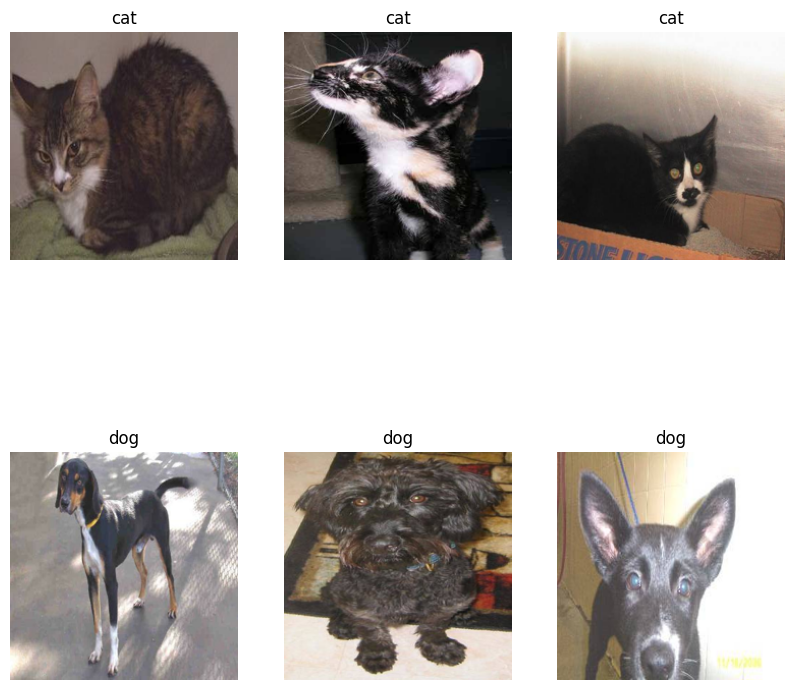

In [112]:
train_images = os.path.join(image_path, "train")

image_size = (image_resize, image_resize)

def display_images(directory):
    plt.figure(figsize=(10, 10))
    categories = os.listdir(directory)
    for category in categories:
        category_dir = os.path.join(directory, category)
        images = [file for file in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, file))]
        for i in range(3):
            img_name = random.choice(images)
            img_path = os.path.join(category_dir, img_name)

            img = Image.open(img_path)
            img = img.resize(image_size)

            plt.subplot(2, 3, categories.index(category) * 3 + i + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    plt.show()

display_images(train_images)

## 3.2 Validation Images

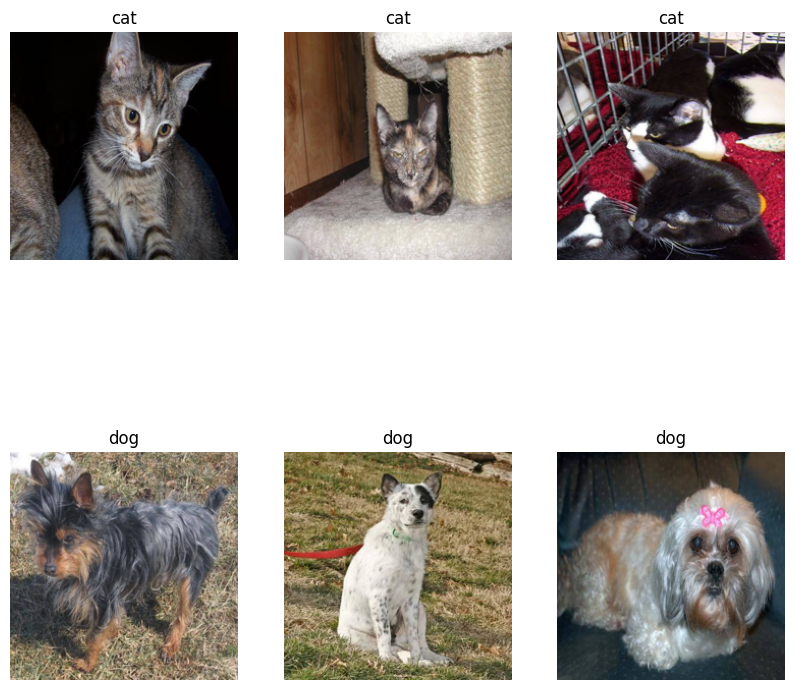

In [113]:
validation_images = os.path.join(image_path, "validation")

image_size = (image_resize, image_resize)

def display_images(directory):
    plt.figure(figsize=(10, 10))
    categories = os.listdir(directory)
    for category in categories:
        category_dir = os.path.join(directory, category)
        images = [file for file in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, file))]
        for i in range(3):
            img_name = random.choice(images)
            img_path = os.path.join(category_dir, img_name)

            img = Image.open(img_path)
            img = img.resize(image_size)

            plt.subplot(2, 3, categories.index(category) * 3 + i + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    plt.show()

display_images(validation_images)

# 4. Model Training

## 4.1 MobileNet Model

### 4.1.1 Load the Pre-Trained MobileNet Model

In [114]:
model_name = "MobileNet"
run_name = create_runname(model_name)
print(run_name)

MobileNet_2024_06_01__020001


In [115]:
mobilenet = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
    )

### 4.1.2 Modify MobileNet Model

In [116]:
x = mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

model = Model(inputs=mobilenet.input, outputs=predictions)

for layer in mobilenet.layers:
    layer.trainable = False

In [117]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [118]:
logdir = os.path.join(current_directory, "logs", experiment_name, run_name)
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=patience, verbose=1, mode="max"),
    ModelCheckpoint(filepath=f"{experiment_name}_{run_name}.keras", monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=False, verbose=1),
    TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)
]

### 4.1.3 MobileNet Summary

In [119]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

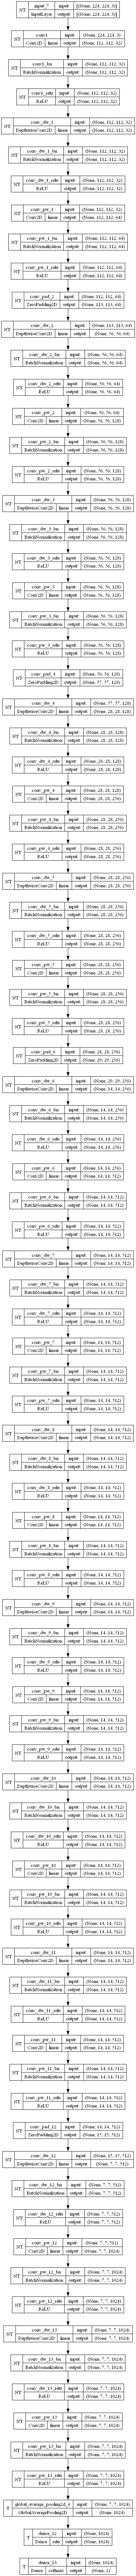

In [120]:
plot_model(model, to_file=f"{model_name}_model.png", show_shapes=True, show_layer_names=True, show_trainable=True, show_layer_activations=True)

In [121]:
mobilenet_start = time.time()
mobilenet_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    callbacks=callbacks
)
mobilenet_end = time.time()
mobilenet_training = (mobilenet_end - mobilenet_start) / 60 # duration in minutes
mobilenet_training = f"{mobilenet_training:.2f}"

Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 0.7828 - accuracy: 0.6658
Epoch 1: val_accuracy improved from -inf to 0.76242, saving model to cat_dog_classification_MobileNet_2024_06_01__020001.keras
625/625 [==============================] - 241s 383ms/step - loss: 0.7828 - accuracy: 0.6658 - val_loss: 0.4996 - val_accuracy: 0.7624
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.6748
Epoch 2: val_accuracy did not improve from 0.76242
625/625 [==============================] - 248s 396ms/step - loss: 0.5925 - accuracy: 0.6748 - val_loss: 0.6354 - val_accuracy: 0.6599
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.5768 - accuracy: 0.6977
Epoch 3: val_accuracy did not improve from 0.76242
625/625 [==============================] - 247s 396ms/step - loss: 0.5768 - accuracy: 0.6977 - val_loss: 0.4889 - val_accuracy: 0.7616
Epoch 3: early stopping


In [122]:
model_file_path = f"{experiment_name}_{run_name}.keras"
model.save(model_file_path)
model_size = os.path.getsize(model_file_path) / (1024 * 1024)  # size in MBs
model_size = (f"{model_size:.2f}")

In [123]:
model = load_model(model_file_path)

### 4.1.4 Registering MobileNet on MLflow

In [124]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name=run_name) as mlflow_run:
    #mlflow.set_experiment_tag("base_model", "MobileNet")
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "categorical_crossentropy")

    mlflow.log_param("Learning Rate", learning_rate)
    mlflow.log_param("Num. of Epochs", num_epochs)
    mlflow.log_param("Batch Size", batch_size)
    mlflow.log_param("Input Shape", input_shape)
    mlflow.log_param("Training Duration Mins", mobilenet_training)
    mlflow.log_param("Model Size MBs", model_size)

    best_val_acc_index = np.argmax(mobilenet_history.history["val_accuracy"])
    mlflow.log_metric("train_loss", mobilenet_history.history["loss"][best_val_acc_index])
    mlflow.log_metric("train_acc", mobilenet_history.history["accuracy"][best_val_acc_index])
    mlflow.log_metric("val_loss", mobilenet_history.history["val_loss"][best_val_acc_index])
    mlflow.log_metric("val_acc", mobilenet_history.history["val_accuracy"][best_val_acc_index])

    mlflow.log_artifact(f"{model_name}_model.png", "model_plot")

    mlflow.keras.log_model(model, artifact_path="models", registered_model_name=f"{model_name}")

    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID: ", mlflow_run_id)

2024/06/01 02:12:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Arda\AppData\Local\Temp\tmpkvc91kz0\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Arda\AppData\Local\Temp\tmpkvc91kz0\model\data\model\assets
Registered model 'MobileNet' already exists. Creating a new version of this model...
2024/06/01 02:12:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MobileNet, version 3


MLFlow Run ID:  66c22fc810d741a4bc70dd1c643ca4b1


Created version '3' of model 'MobileNet'.


## 4.2 VGG16 Model

### 4.2.1 Load the Pre-Trained VGG16 Model

In [125]:
model_name = "VGG16"
run_name = create_runname(model_name)
print(run_name)

VGG16_2024_06_01__021235


In [126]:
vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
    )

### 4.2.2 Modify VGG16 Model

In [127]:
x = vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

model = Model(inputs=vgg16.input, outputs=predictions)

for layer in vgg16.layers:
    layer.trainable = False

In [128]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [129]:
logdir = os.path.join(current_directory, "logs", experiment_name, run_name)
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=patience, verbose=1, mode="max"),
    ModelCheckpoint(filepath=f"{experiment_name}_{run_name}.keras", monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=False, verbose=1),
    TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)
]

### 4.2.3 VGG16 Summary

In [130]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

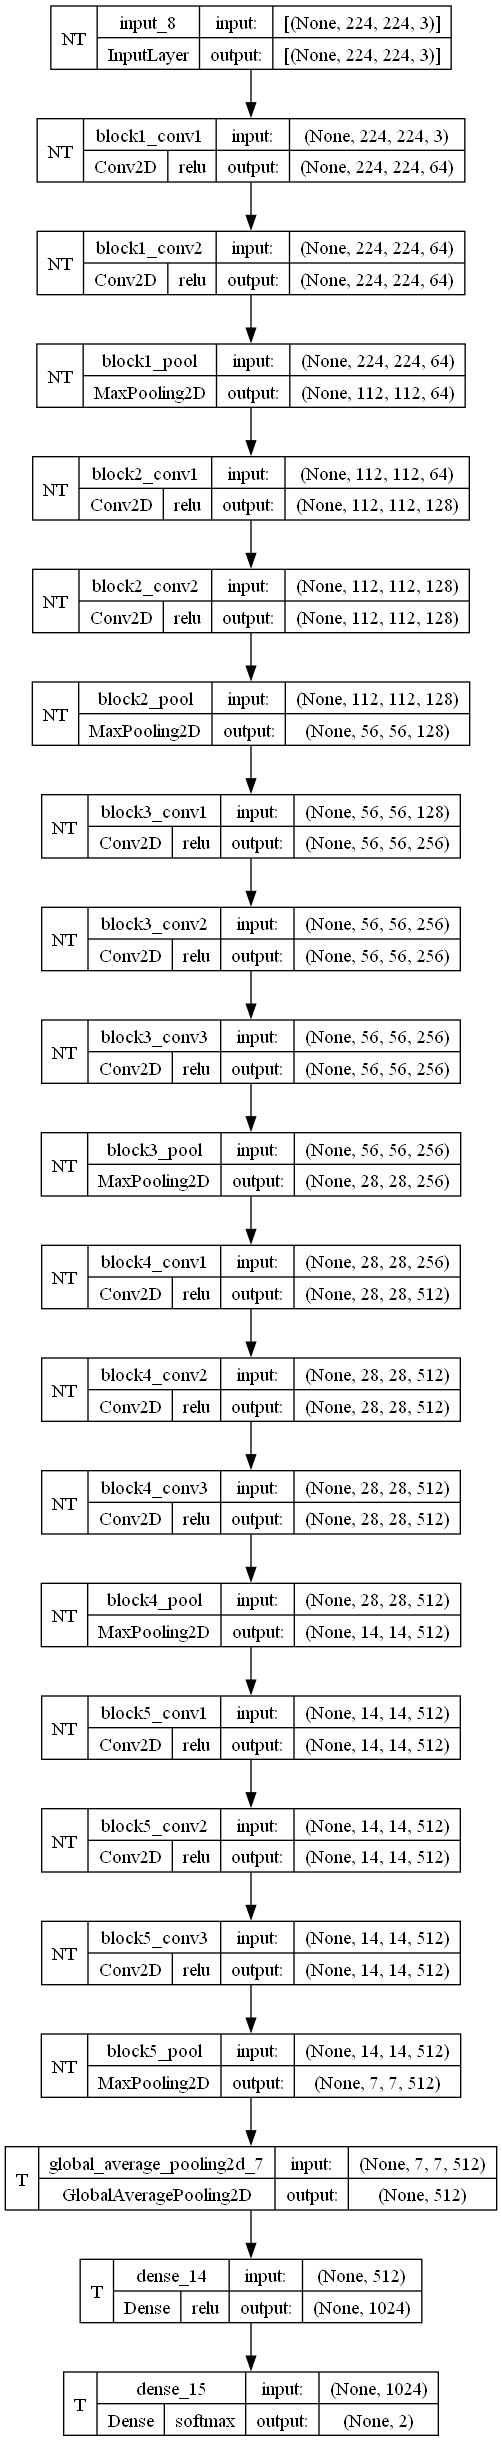

In [131]:
plot_model(model, to_file=f"{model_name}_model.png", show_shapes=True, show_layer_names=True, show_trainable=True, show_layer_activations=True)

In [132]:
vgg16_start = time.time()
vgg16_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    callbacks=callbacks
)
vgg16_end = time.time()
vgg16_training = (vgg16_end - vgg16_start) / 60 # duration in minutes
vgg16_training = f"{vgg16_training:.2f}"

Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.9178
Epoch 1: val_accuracy improved from -inf to 0.93790, saving model to cat_dog_classification_VGG16_2024_06_01__021235.keras
625/625 [==============================] - 1756s 3s/step - loss: 0.4909 - accuracy: 0.9178 - val_loss: 0.1540 - val_accuracy: 0.9379
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9263
Epoch 2: val_accuracy improved from 0.93790 to 0.96695, saving model to cat_dog_classification_VGG16_2024_06_01__021235.keras
625/625 [==============================] - 1788s 3s/step - loss: 0.1840 - accuracy: 0.9263 - val_loss: 0.0992 - val_accuracy: 0.9669
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9300
Epoch 3: val_accuracy improved from 0.96695 to 0.97135, saving model to cat_dog_classification_VGG16_2024_06_01__021235.keras
625/625 [==============================] - 1811s 3s/step - loss: 0.1703 - 

In [133]:
model_file_path = f"{experiment_name}_{run_name}.keras"
model.save(model_file_path)
model_size = os.path.getsize(model_file_path) / (1024 * 1024)  # size in MBs
model_size = (f"{model_size:.2f}")

In [134]:
model = load_model(model_file_path)

### 4.2.4 Registering VGG16 on MLflow

In [135]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name=run_name) as mlflow_run:
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "categorical_crossentropy")

    mlflow.log_param("Learning Rate", learning_rate)
    mlflow.log_param("Num. of Epochs", num_epochs)
    mlflow.log_param("Batch Size", batch_size)
    mlflow.log_param("Input Shape", input_shape)
    mlflow.log_param("Training Duration Mins", vgg16_training)
    mlflow.log_param("Model Size MBs", model_size)

    best_val_acc_index = np.argmax(vgg16_history.history["val_accuracy"])
    mlflow.log_metric("train_loss", vgg16_history.history["loss"][best_val_acc_index])
    mlflow.log_metric("train_acc", vgg16_history.history["accuracy"][best_val_acc_index])
    mlflow.log_metric("val_loss", vgg16_history.history["val_loss"][best_val_acc_index])
    mlflow.log_metric("val_acc", vgg16_history.history["val_accuracy"][best_val_acc_index])

    mlflow.log_artifact(f"{model_name}_model.png", "model_plot")

    mlflow.keras.log_model(model, artifact_path="models", registered_model_name=f"{model_name}")

    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID: ", mlflow_run_id)

2024/06/01 04:41:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Arda\AppData\Local\Temp\tmpf7f5okcb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Arda\AppData\Local\Temp\tmpf7f5okcb\model\data\model\assets
Registered model 'VGG16' already exists. Creating a new version of this model...
2024/06/01 04:41:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: VGG16, version 3


MLFlow Run ID:  0ae51b140af848ffb33238ec39482d7c


Created version '3' of model 'VGG16'.


## 4.3 ResNet50 Model

### 4.3.1 Load the Pre-Trained ResNet50 Model

In [136]:
model_name = "ResNet50"
run_name = create_runname(model_name)
print(run_name)

ResNet50_2024_06_01__044149


In [137]:
resnet50 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

### 4.3.2 Modify MobileNet Model

In [138]:
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

model = Model(inputs=resnet50.input, outputs=predictions)

for layer in resnet50.layers:
    layer.trainable = False

In [139]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [140]:
logdir = os.path.join(current_directory, "logs", experiment_name, run_name)
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=patience, verbose=1, mode="max"),
    ModelCheckpoint(filepath=f"{experiment_name}_{run_name}.keras", monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=False, verbose=1),
    TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)
]

### 4.3.3 ResNet50 Summary

In [141]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

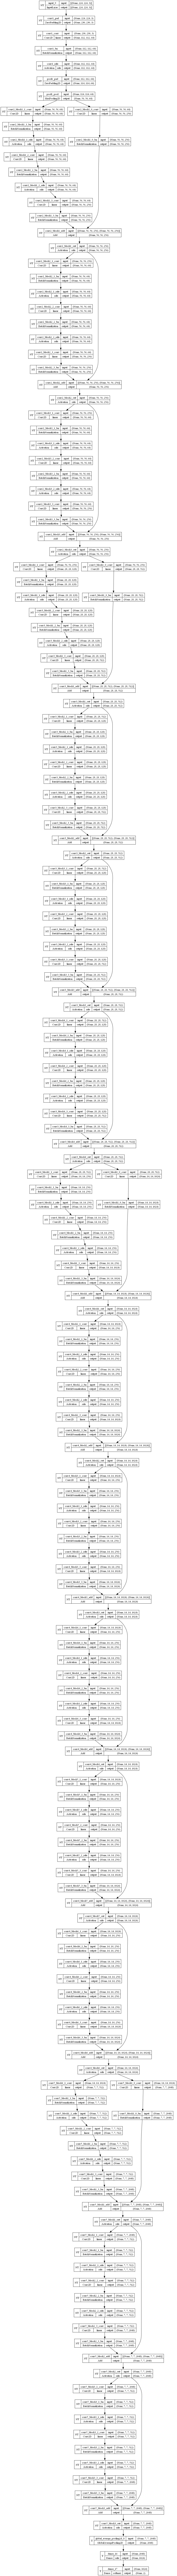

In [142]:
plot_model(model, to_file=f"{model_name}_model.png", show_shapes=True, show_layer_names=True, show_trainable=True, show_layer_activations=True)

In [143]:
resnet50_start = time.time()
resnet50_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    callbacks=callbacks
)
resnet50_end = time.time()
resnet50_training = (resnet50_end - resnet50_start) / 60 # duration in minutes
resnet50_training = f"{resnet50_training:.2f}"

Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 0.4730 - accuracy: 0.9280
Epoch 1: val_accuracy improved from -inf to 0.97636, saving model to cat_dog_classification_ResNet50_2024_06_01__044149.keras
625/625 [==============================] - 685s 1s/step - loss: 0.4730 - accuracy: 0.9280 - val_loss: 0.0777 - val_accuracy: 0.9764
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9361
Epoch 2: val_accuracy did not improve from 0.97636
625/625 [==============================] - 689s 1s/step - loss: 0.1528 - accuracy: 0.9361 - val_loss: 0.0701 - val_accuracy: 0.9734
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9394
Epoch 3: val_accuracy did not improve from 0.97636
625/625 [==============================] - 696s 1s/step - loss: 0.1526 - accuracy: 0.9394 - val_loss: 0.1020 - val_accuracy: 0.9724
Epoch 3: early stopping


In [144]:
model_file_path = f"{experiment_name}_{run_name}.keras"
model.save(model_file_path)
model_size = os.path.getsize(model_file_path) / (1024 * 1024)  # size in MBs
model_size = (f"{model_size:.2f}")

In [145]:
model = load_model(model_file_path)

### 4.3.4 Registering ResNet50 on MLflow

In [146]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name=run_name) as mlflow_run:
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "categorical_crossentropy")

    mlflow.log_param("Learning Rate", learning_rate)
    mlflow.log_param("Num. of Epochs", num_epochs)
    mlflow.log_param("Batch Size", batch_size)
    mlflow.log_param("Input Shape", input_shape)
    mlflow.log_param("Training Duration Mins", resnet50_training)
    mlflow.log_param("Model Size MBs", model_size)

    best_val_acc_index = np.argmax(resnet50_history.history["val_accuracy"])
    mlflow.log_metric("train_loss", resnet50_history.history["loss"][best_val_acc_index])
    mlflow.log_metric("train_acc", resnet50_history.history["accuracy"][best_val_acc_index])
    mlflow.log_metric("val_loss", resnet50_history.history["val_loss"][best_val_acc_index])
    mlflow.log_metric("val_acc", resnet50_history.history["val_accuracy"][best_val_acc_index])

    mlflow.log_artifact(f"{model_name}_model.png", "model_plot")

    mlflow.keras.log_model(model, artifact_path="models", registered_model_name=f"{model_name}")

    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID: ", mlflow_run_id)

2024/06/01 05:16:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Arda\AppData\Local\Temp\tmpjpvb7yjh\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Arda\AppData\Local\Temp\tmpjpvb7yjh\model\data\model\assets
Registered model 'ResNet50' already exists. Creating a new version of this model...
2024/06/01 05:16:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ResNet50, version 3


MLFlow Run ID:  98b69cc4642a43a98142b783f3d8ec0d


Created version '3' of model 'ResNet50'.


# 5. Model Evaluation

## 5.1 Tensorboard

In [147]:
%load_ext tensorboard
%tensorboard --logdir c:/Users/Arda/Desktop/Projects/Cat_Dog_Classifier_App/logs/cat_dog_classification

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16252), started 1 day, 11:57:38 ago. (Use '!kill 16252' to kill it.)

## 5.2 Performance Metrics Plots

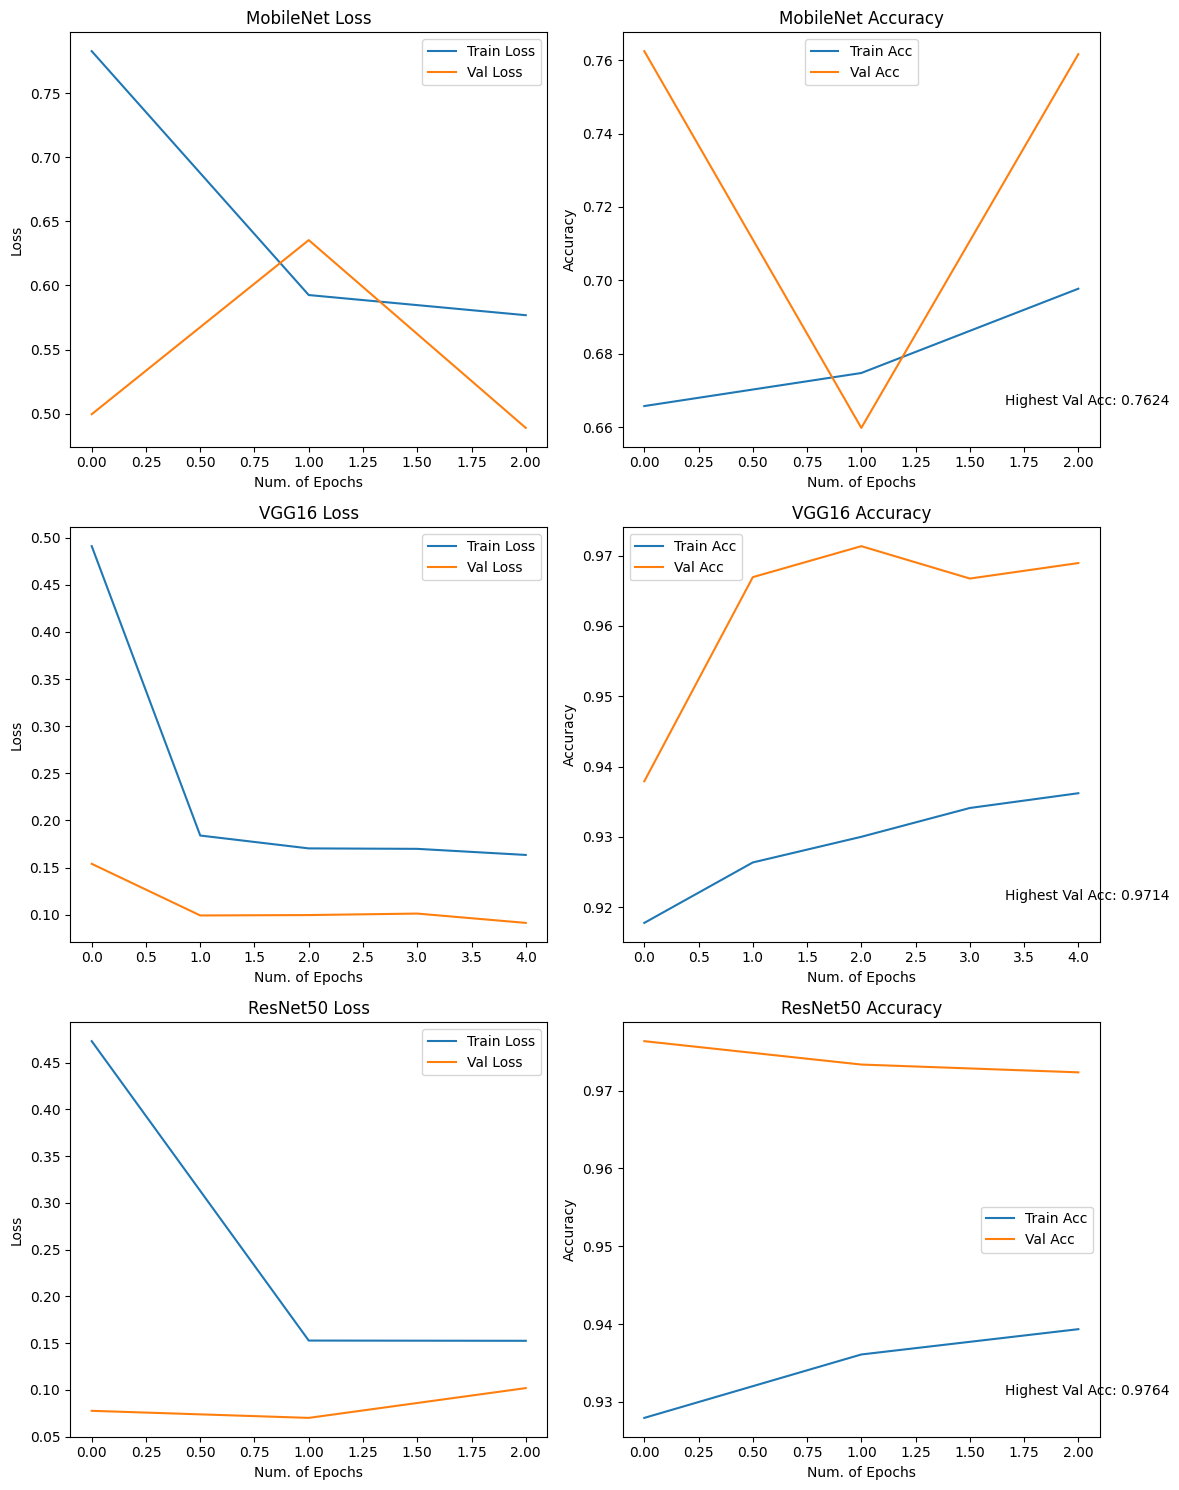

In [148]:
def plot_model_performance(histories, model_names):
    num_models = len(histories)
    fig, axes = plt.subplots(num_models, 2, figsize=(12, 5 * num_models))

    for i, (history, model_name) in enumerate(zip(histories, model_names)):
        # Plot Loss
        axes[i, 0].plot(history['loss'], label='Train Loss')
        axes[i, 0].plot(history['val_loss'], label='Val Loss')
        axes[i, 0].set_title(f"{model_name} Loss")
        axes[i, 0].set_xlabel("Num. of Epochs")
        axes[i, 0].set_ylabel("Loss")
        axes[i, 0].legend()

        # Plot Accuracy
        axes[i, 1].plot(history['accuracy'], label='Train Acc')
        axes[i, 1].plot(history['val_accuracy'], label='Val Acc')
        axes[i, 1].set_title(f"{model_name} Accuracy")
        axes[i, 1].set_xlabel("Num. of Epochs")
        axes[i, 1].set_ylabel("Accuracy")
        axes[i, 1].legend()
        axes[i, 1].text(0.8, 0.1, f"Highest Val Acc: {max(history['val_accuracy']):.4f}", transform=axes[i, 1].transAxes)

    plt.tight_layout()
    plt.show()

# Example usage:
histories = [mobilenet_history.history, vgg16_history.history, resnet50_history.history]
model_names = ['MobileNet', 'VGG16', 'ResNet50']
plot_model_performance(histories, model_names)

# 6. Prediction

## 6.1 Display All The Three Models from MLflow

In [149]:
def display_registered_models():
    try:
        client = mlflow.tracking.MlflowClient()

        registered_models = client.search_registered_models()

        for model in registered_models:
            print(f"Model Name: {model.name}")

            versions = client.get_latest_versions(model.name)
            for version in versions:
                print(f"  Version: {version.version}")
                print(f"  Stage: {version.current_stage}")
                print(f"  Run ID: {version.run_id}")
                print(f"  Status: {version.status}")

    except Exception as e:
        print(f"An error occurred: {e}")


display_registered_models()

Model Name: MobileNet
  Version: 3
  Stage: None
  Run ID: 66c22fc810d741a4bc70dd1c643ca4b1
  Status: READY
Model Name: ResNet50
  Version: 3
  Stage: None
  Run ID: 98b69cc4642a43a98142b783f3d8ec0d
  Status: READY
Model Name: VGG16
  Version: 3
  Stage: None
  Run ID: 0ae51b140af848ffb33238ec39482d7c
  Status: READY


C:\Users\Arda\AppData\Local\Temp\ipykernel_13924\2252671110.py:10: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  versions = client.get_latest_versions(model.name)


# 6.2 Load All The Three Models From MLflow

In [150]:
def load_registered_models():
    loaded_models = {}  # Dictionary to store loaded models

    try:
        client = mlflow.tracking.MlflowClient()
        registered_models = client.search_registered_models()

        for model in registered_models:
            print(f"Model Name: {model.name}")

            versions = client.get_latest_versions(model.name)
            for version in versions:                
                model_path = f"runs:/{version.run_id}/models"
                loaded_model = mlflow.keras.load_model(model_path)  # Load model

                # Store model in the dictionary
                loaded_models[model.name] = loaded_model
                print(f"Loaded model '{model.name}'")

    except Exception as e:
        print(f"An error occurred: {e}")

    return loaded_models

# Call the function to load registered models
loaded_models = load_registered_models()

# Print loaded_models to inspect its contents
print(loaded_models)

Model Name: MobileNet


C:\Users\Arda\AppData\Local\Temp\ipykernel_13924\278541422.py:11: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  versions = client.get_latest_versions(model.name)


Loaded model 'MobileNet'
Model Name: ResNet50


C:\Users\Arda\AppData\Local\Temp\ipykernel_13924\278541422.py:11: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  versions = client.get_latest_versions(model.name)


Loaded model 'ResNet50'
Model Name: VGG16


C:\Users\Arda\AppData\Local\Temp\ipykernel_13924\278541422.py:11: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  versions = client.get_latest_versions(model.name)


Loaded model 'VGG16'
{'MobileNet': <keras.src.engine.functional.Functional object at 0x000001EB2D6C5790>, 'ResNet50': <keras.src.engine.functional.Functional object at 0x000001EBF3858790>, 'VGG16': <keras.src.engine.functional.Functional object at 0x000001EC013DC250>}


In [151]:
for model_name, model in loaded_models.items():
    print(model_name, model)

MobileNet <keras.src.engine.functional.Functional object at 0x000001EB2D6C5790>
ResNet50 <keras.src.engine.functional.Functional object at 0x000001EBF3858790>
VGG16 <keras.src.engine.functional.Functional object at 0x000001EC013DC250>


In [152]:
MobileNet_model = loaded_models.get("MobileNet")
VGG16_model = loaded_models.get("VGG16")
ResNet50_model = loaded_models.get("ResNet50")

1/1 [==============================] - 0s 104ms/step


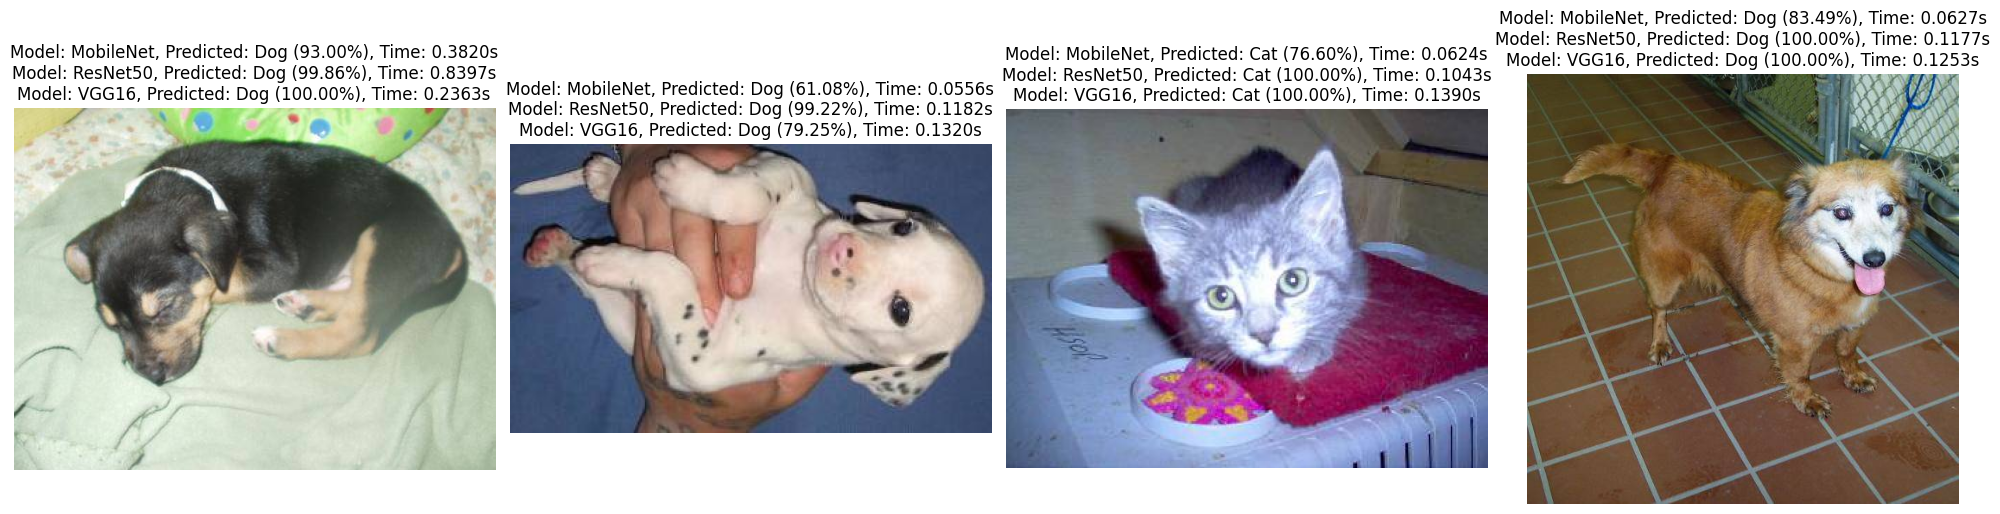

In [153]:
def predict_image_category(image_path, loaded_models, input_shape):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=input_shape[:2]
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    results = []

    for model_name, model in loaded_models.items():
        try:
            start_time = time.time()
            predictions = model.predict(img_array)
            end_time = time.time()
            prediction_time = end_time - start_time
            
            predicted_category = "Dog" if predictions[0][0] < predictions[0][1] else "Cat"
            confidence = max(predictions[0]) * 100
            results.append("Model: {}, Predicted: {} ({:.2f}%), Time: {:.4f}s".format(
                model_name, predicted_category, confidence, prediction_time))
        except Exception as e:
            results.append("Error predicting with model {}: {}".format(model_name, e))
    
    return results

test_dir = os.path.join(os.getcwd(), "test_images")
image_files = os.listdir(test_dir)
random_images = random.sample(image_files, 4)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, image_file in enumerate(random_images):
    image_path = os.path.join(test_dir, image_file)
    results = predict_image_category(image_path, loaded_models, input_shape)
    axes[i].imshow(keras.preprocessing.image.load_img(image_path))
    axes[i].axis('off')
    axes[i].set_title('\n'.join(results))

plt.tight_layout()
plt.show()